# Imports

In [8]:
import mujoco
import distutils.util
import os
import subprocess
import mediapy as media
import matplotlib.pyplot as plt
import time
import itertools
import numpy as np

# Viewer 

If you want to see in real time the system:

1.  Open the terminal 
2.  Change the envirorment where mujoco library is installed ( using *conda*)
3.  Go to the git folder path (`cd $PATH/MirrorSim` or `dir $PATH/MirrorSim`)
4.  Run the command `python -m mujoco.viewer`


# CODE

Where to edit the model (xml) and show an image of the system

""

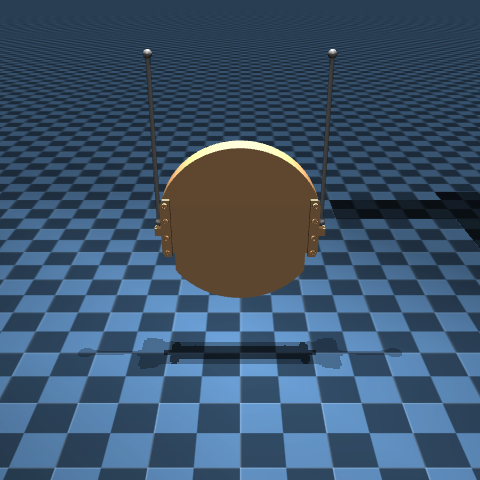

In [3]:



MJCF = """

<mujoco>
  
<!-- Parte visuale -->

  <compiler  texturedir="asset"/>


  <statistic meansize=".05"/>

  <visual>
    <rgba haze="0.15 0.25 0.35 1"/>
    <quality shadowsize="4096"/>
    <map stiffness="700" shadowscale="0.5" fogstart="1" fogend="15" zfar="40" haze="1"/>
  </visual>

  <asset>
    <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 0.15 0.2" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>

    <material name="matplane"  texture="texplane" texrepeat="10 10" texuniform="true"/>       <!--Se vuoi il riflesso del pavimento +reflectance="0.3"+ -->
  </asset>

  <worldbody>
    <light diffuse=".4 .4 .4" specular="0.1 0.1 0.1" pos="0 0 2.0" dir="0 0 -1" castshadow="false"/>
    <light directional="true" diffuse=".8 .8 .8" specular="0.2 0.2 0.2" pos="0 0 4" dir="0 0 -1"/>

    <geom name="ground" type="plane" size="0 0 1" pos="0 0 -0.5" quat="1 0 0 0" material="matplane" condim="1"/>
  </worldbody>

<!-- Finita parte visuale  -->  


<!-- Finita parte prove  -->  


  <asset>
    <material name="mirror" reflectance="1"/>             <!-- caratteristiche -->
    <material name="wire_mat" rgba="0.8 0.8 0.8 1"/>

    
    <!-- CAMBIARE IL PATH DEI FILE STL -->

    <mesh name="specchio" file="STL/Specchio2.stl" scale="0.002 0.002 0.002" />                        <!-- Specchio collegamento al file STL -->
  
    
    <!-- Fibre collegamento al file STL -->
    
    <!--
    
    <mesh name="Fibra1" file="STL/assieme_dondola1-Fibra_1.15-1.STL" scale="0.002 0.002 0.002" />      <!-- Fibra 1 collegamento al file STL -->
    <mesh name="Fibra2" file="STL/assieme_dondola1-Fibra_1.15-2.STL" scale="0.002 0.002 0.002" />      
    
    -->

  
  <!-- ========================================================================================================  -->

  </asset>

  <option gravity="0 0 -9.81" viscosity="0.00002"/>             <!-- Parametri fisici -->

  <worldbody>
    <light name="light" pos="0 0 1"/>                           <!-- Luce -->
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/> <!-- Telecamera -->
    <site name="anchor1" pos="-.2 0 .3" size=".01"/>            <!-- Punto dove metti la corda  -->
    <site name="anchor2" pos=".2 0 .3" size=".01"/>             <!-- Punto dove metti la corda  -->


  <!-- I due cavi che collegano lo specchio -->
       
<!--
    <body name="Fibra1" pos="-.212 -.242 -.07">       
      <geom type="mesh" mesh="Fibra1"  pos="0 0 -0.37" rgba="0.8 0.6 0.4 1" size=".2" euler="90 90 0" />         
    </body>
    
    <body name="Fibra2" pos="-.212 -.242 -.07">       
      <geom type="mesh" mesh="Fibra2"  pos="0 0 -0.37" rgba="0.8 0.6 0.4 1" size=".2" euler="90 90 0" />         
    </body>
-->
   

  <!-- ========================================================================================================  -->

                                                                                                                      
  <!-- Specchio che si muove e riflette -->                                                                                                                  
    <body name="cilindro" pos="0 0 -.1">
      <joint name="free" type="free"/>
      <geom type="mesh" mesh="specchio"  pos="0 0 -0.37" rgba="0.8 0.6 0.4 1" size=".2" euler="90 90 0" />          <!--Centro di massa si trova verso il 2 buco (-0.37), ma non stai considerando i pasetti e tutto-->
      <site name="hook1" pos="-.2 0 0" size=".01"/>                                                                 <!-- L'attacco si trova a -0.3455 -->
      <site name="hook2" pos=".2 0 0" size=".01"/>
      <site name="IMU"/>
    </body>

    
  <!-- ========================================================================================================  -->




  </worldbody>


<!-- PER VEDERE GLI ASSI CARTESIANI https://mujoco.readthedocs.io/en/latest/programming/samples.html#sasimulate -->


  <worldbody>
    <body name="x" pos="0.8 1 1">
        <geom name="x" type="box" size="0.4 0.1 0.1" pos="0 0 0" rgba="1 0 0 1"/>
    </body>
    <body name="y" pos="1 0.8 1">
      <geom name="y" type="box" size="0.1 0.4 0.1" pos="0 0 0" rgba="0 1 0 1"/>
    </body>
    <body name="z" pos="1 1 0.8">
    <geom name="z" type="box" size="0.1 0.1 0.4" pos="0 0 0" rgba="0 0 1 1"/>
    </body> 
  </worldbody>

  
  <!-- ========================================================================================================  -->

  <tendon>
    <spatial name="wire1" limited="true" range="0 0.35" width="0.005" damping="0.1">
      <site site="anchor1"/>
      <site site="hook1"/>
    </spatial>
  </tendon>
  
  <tendon>
    <spatial name="wire2" limited="true" range="0 0.35" width="0.005" damping="0.1">
      <site site="anchor2"/>
      <site site="hook2"/>
    </spatial>
  </tendon>

  


  
  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>

</mujoco>
"""


model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
height = 480
width = 480

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())





Simulation of the system with a 6 sec of video at 60 fps.
Here you can extract data like accelerometer and time.


In [4]:
n_frames = 400     # number of frames = time * fps   es  400frames = 6sec * 60fps
fps = 60.0          

height = 240        #grandezza immagini
width = 320

frames = []         #immagini
times = []          #tempo
sensordata = []     #dati sensore

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/fps:
      mujoco.mj_step(model, data)
      #mujoco.mj_applyFT(model, data, my_force, my_torque, point_on_body, bodyid, data.qfrc_applied)   #Applicare forze

      times.append(data.time)
      sensordata.append(data.sensor('accelerometer').data.copy())      #dati sensore
    renderer.update_scene(data, "fixed")                              #immagini di ogni frame (fixed ha il sistema fisico)
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=fps)


#Per la forza applicata sul corpo:
# https://github.com/google-deepmind/mujoco/discussions/641

Graphical rappresentation of accelerometer

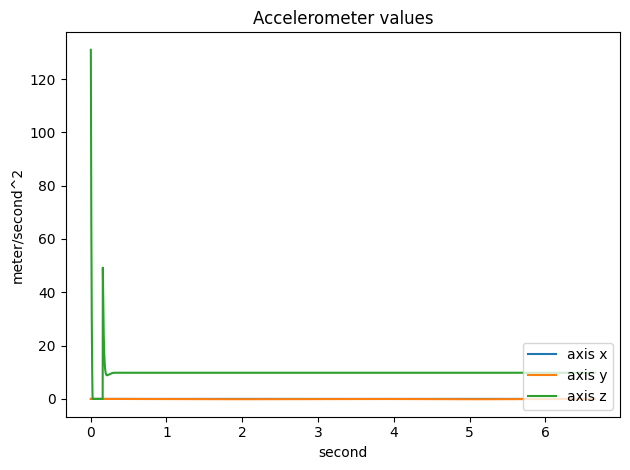

In [5]:
ax = plt.gca()

ax.plot(np.asarray(times), np.asarray(sensordata), label=[f"axis {v}" for v in ['x', 'y', 'z']])

# finalize plot
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right')
plt.tight_layout()

# TESTS

In [8]:
#coord (x, y, z)
#puoi usare il viewr per il modello basta inserire il comando "python -m mujoco.viewer model.xml" oppure attivi e poi trascini l xml
"""
Struttura per xml
nome= virgolette

<mujoco>
    <asset>
        crei/ ridefinisci cose nuove cosi chiami texture/oggetti/materiali una volta per tutte
    </asset>

    <worldbody>
        crei  cose che vanno nel simulatore , puoi creare piu cose 
        <light name="top" pos="0 0 2"/> (definisce luce in posizione z=2 0,0=x,y nominato top)
        <geom name="pole" type="capsule" fromto="0 0 .04 0 -.3 .04" size=".04" rgba="0 0 1 1"/> (definisce una capsula di lungezza da a (x-> x+dx) e il colore)
        <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/> (definisce la telecamera e in che posizione NB puo essere modificata ma guarda tutorial)
        (NB se vuoi creare un oggetto con giunte:)
        <body name="box_and_sphere" pos="0 0 0">
            <joint name="swing" type="hinge" damping="1" axis="0 0 1"/> (hinge dice che pendola e dici dove attaccato)
            <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/> (oggetto attaccato)
        </body>

    </worldbody>
    (crea un motore per il pendolo e permette di oscillare l'oggetto)
    <actuator>
        <motor name="my_motor" joint="swing" gear="1"/>
    </actuator>

    <tendon>
        <spatial name="wire" limited="true" range="0 0.35" width="0.003">
        <site site="anchor"/>
        <site site="hook"/>
        </spatial>
    </tendon>
    
    <sensor>
        <accelerometer name="accelerometer" site="IMU"/>
    </sensor>
</mujoco>
virgolette
"""

'\nStruttura per xml\nnome= virgolette\n\n<mujoco>\n    <asset>\n        crei/ ridefinisci cose nuove cosi chiami texture/oggetti/materiali una volta per tutte\n    </asset>\n\n    <worldbody>\n        crei  cose che vanno nel simulatore , puoi creare piu cose \n        <light name="top" pos="0 0 2"/> (definisce luce in posizione z=2 0,0=x,y nominato top)\n        <geom name="pole" type="capsule" fromto="0 0 .04 0 -.3 .04" size=".04" rgba="0 0 1 1"/> (definisce una capsula di lungezza da a (x-> x+dx) e il colore)\n        <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/> (definisce la telecamera e in che posizione NB puo essere modificata ma guarda tutorial)\n        (NB se vuoi creare un oggetto con giunte:)\n        <body name="box_and_sphere" pos="0 0 0">\n            <joint name="swing" type="hinge" damping="1" axis="0 0 1"/> (hinge dice che pendola e dici dove attaccato)\n            <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/> (oggetto attaccato)\n  

""

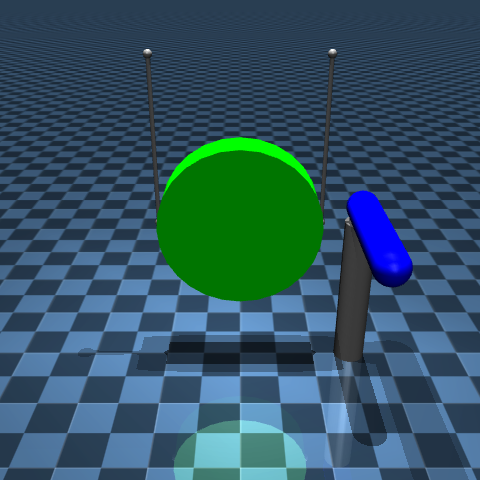

In [9]:
MJCF = """

<mujoco>

  <compiler meshdir="asset" texturedir="asset"/>

  <statistic meansize=".05"/>

  <visual>
    <rgba haze="0.15 0.25 0.35 1"/>
    <quality shadowsize="4096"/>
    <map stiffness="700" shadowscale="0.5" fogstart="1" fogend="15" zfar="40" haze="1"/>
  </visual>

  <asset>
    <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 0.15 0.2" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>

    <material name="matplane" reflectance="0.3" texture="texplane" texrepeat="10 10" texuniform="true"/>
  </asset>

  <worldbody>
    <light diffuse=".4 .4 .4" specular="0.1 0.1 0.1" pos="0 0 2.0" dir="0 0 -1" castshadow="false"/>
    <light directional="true" diffuse=".8 .8 .8" specular="0.2 0.2 0.2" pos="0 0 4" dir="0 0 -1"/>

    <geom name="ground" type="plane" size="0 0 1" pos="0 0 -0.5" quat="1 0 0 0" material="matplane" condim="1"/>
  </worldbody>

<!-- Finita parte visuale  -->  

<!-- 
  <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="512"/>
  <geom name="floor" type="plane" pos="0 0 -0.5" size="5 5 .1" material="grid"/>
  <texture name="grid" type="2d" builtin="checker" rgb1=".2 .2 .2" rgb2="1 1 1" width="300" height="300" mark="none"/>
  <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>   
-->

<!-- Finita parte prove  -->  


  <asset>
    <material name="mirror" reflectance="1"/>
    <material name="wire_mat" rgba="0.8 0.8 0.8 1"/>
  </asset>

  <option gravity="0 0 -9.81"viscosity="0.00002"/>

  <worldbody>
    <light name="light" pos="0 0 1"/>


    <site name="anchor1" pos="-.2 0 .3" size=".01"/>           <!--Punto dove metti la corda -->
    <site name="anchor2" pos=".2 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>
    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>



    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>
  

  
    <body name="cilindro" pos="0 0 -.1">
      <joint name="free" type="free"/>
      <geom name="cilindro"  size=".2" fromto="0 .05 0 0 -.05 0"  rgba="0 1 0 1" type="cylinder"/>
      <site name="hook1" pos="-.2 0 0" size=".01"/>
      <site name="hook2" pos=".2 0 0" size=".01"/>
      <site name="IMU"/>
    </body>




  </worldbody>

  
  <tendon>
    <spatial name="wire1" limited="true" range="0 0.35" width="0.005" damping="0.1">
      <site site="anchor1"/>
      <site site="hook1"/>
    </spatial>
  </tendon>
  
  <tendon>
    <spatial name="wire2" limited="true" range="0 0.35" width="0.005" damping="0.1">
      <site site="anchor2"/>
      <site site="hook2"/>
    </spatial>
  </tendon>

<!--
  <contact>
    <exclude body1="wire1" body2="cilindro"/>
    <exclude body1="wire2" body2="cilindro"/>
  </contact>
-->
  <actuator>
    <motor name="my_motor" joint="swing"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""


model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
height = 480
width = 480

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())